# ResNet-50 Implementation

## Introduction to ResNet (Residual Network)

__ResNet__ or __Residual Neural Network__ was proposed by researchers at Microsoft Research namely, _Kaiming He_, _Xiangyu Zhang_, _Shaoqing Ren_ and, _Jian Sun_; which also won [ImageNet](https://www.image-net.org/about.php) Challenge in 2015.

<center>
    <img src="./img/MicrosoftResearch.png" alt="Microsoft Research" width="500px"> <br>
</center>

## Importing Dependencies

In [1]:
# Import OpenCV which is a Computer Vision library and here we use it to deal with our image dataset
import cv2

# Import NumPy as our model trains on arrays which will be handled by NumPy
import numpy as np

import scipy

# Import OS to interact with operating system
import os

# Import Math to use some mathematical computations
import math

# Import Shutil to move, copy and delete directories and sub-directories
import shutil

# Import glob module which finds all the pathnames matching a specified pattern according to the rules used by the Unix shell
import glob

# Import mayplotlib to visualize the metrics of our model
import matplotlib.pyplot as plt

# Import Keras
import keras

# Import Keras ImageDataGenerator which is used for getting the input of the original data and further, it makes the transformation of this data on a random basis and gives the output resultant containing only the data that is newly transformed.
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from keras.models import Sequential, Model, load_model
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform
from keras.losses import binary_crossentropy

2022-12-09 20:45:10.287588: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/hamza/.local/lib/python3.10/site-packages/cv2/../../lib64:
2022-12-09 20:45:10.287615: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
DATASET_PATH = "Animal-Classification-Dataset"

In [3]:
number_of_images = {}

for dir in os.listdir(DATASET_PATH):
    number_of_images[dir] = len(os.listdir(os.path.join(DATASET_PATH, dir)))

In [4]:
number_of_images

{'Zebra': 1000, 'Buffalo': 1000}

In [5]:
labels = []

for key in number_of_images.keys():
    labels.append(key)

print(labels)

['Zebra', 'Buffalo']


In [6]:
def data_folder(folder_name, split_ratio):
    if not os.path.exists("./" + folder_name):
        os.mkdir("./" + folder_name)
    
    for dir in os.listdir(DATASET_PATH):
        if not os.path.exists("./" + folder_name + "/" + dir):
            os.makedirs("./" + folder_name + "/" + dir)

        for img in np.random.choice(a = os.listdir(os.path.join(DATASET_PATH, dir)), size = (math.floor(split_ratio * number_of_images[dir])), replace = False):
            O = os.path.join(DATASET_PATH, dir, img)
            D = os.path.join("./" + folder_name, dir)
            shutil.copy(O, D)
    
    else:
        print(f"{folder_name} Folder exist")

In [7]:
data_folder("Train", 0.7)

Train Folder exist


In [8]:
data_folder("Validate", 0.15)

Validate Folder exist


In [9]:
data_folder("Test", 0.15)

Test Folder exist


In [10]:
TRAIN_PATH = "./Train"

In [11]:
TEST_PATH = "./Test"

In [12]:
VALIDATE_PATH = "./Validate"

In [13]:
class_names_train = os.listdir(TRAIN_PATH)

In [14]:
class_names_test = os.listdir(TEST_PATH)

In [15]:
class_names_validate = os.listdir(VALIDATE_PATH)

In [16]:
print(class_names_train)

['Zebra', 'Buffalo']


In [17]:
print(class_names_test)

['Zebra', 'Buffalo']


In [18]:
print(class_names_validate)

['Zebra', 'Buffalo']


In [19]:
train_datagen = ImageDataGenerator(zoom_range = 0.15, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.15)
validate_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

In [20]:
train_generator = train_datagen.flow_from_directory("./Train", target_size = (224, 224), batch_size = 32, shuffle=True, class_mode = 'binary')
validate_generator = validate_datagen.flow_from_directory("./Validate", target_size = (224,224), batch_size = 32, shuffle = False, class_mode='binary')
test_generator = test_datagen.flow_from_directory("./Validate", target_size = (224,224), batch_size = 32, shuffle = False, class_mode='binary')

Found 1400 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


In [21]:
def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X
   
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut]) # SKIP Connection
    X = Activation('relu')(X)

    return X

In [22]:
def convolutional_block(X, f, filters, stage, block, s=2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [23]:
def ResNet50(input_shape=(224, 224, 3)):

    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

In [24]:
base_model = ResNet50(input_shape=(224, 224, 3))

2022-12-09 20:45:33.029126: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/hamza/.local/lib/python3.10/site-packages/cv2/../../lib64:
2022-12-09 20:45:33.029153: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-09 20:45:33.029172: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hamza-VivoBook): /proc/driver/nvidia/version does not exist
2022-12-09 20:45:33.029551: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [25]:
print(base_model)

In [26]:
headModel = base_model.output
headModel = Flatten()(headModel)
headModel = Dense(256, activation='relu', name='fc1',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel = Dense(128, activation='relu', name='fc2',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel = Dense( 1,activation='sigmoid', name='fc3',kernel_initializer=glorot_uniform(seed=0))(headModel)

In [27]:
model = Model(inputs=base_model.input, outputs=headModel)

In [28]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 64  9472        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

                                                                                                  
 activation_8 (Activation)      (None, 55, 55, 64)   0           ['bn2c_branch2b[0][0]']          
                                                                                                  
 res2c_branch2c (Conv2D)        (None, 55, 55, 256)  16640       ['activation_8[0][0]']           
                                                                                                  
 bn2c_branch2c (BatchNormalizat  (None, 55, 55, 256)  1024       ['res2c_branch2c[0][0]']         
 ion)                                                                                             
                                                                                                  
 add_2 (Add)                    (None, 55, 55, 256)  0           ['bn2c_branch2c[0][0]',          
                                                                  'activation_6[0][0]']           
          

 ion)                                                                                             
                                                                                                  
 add_5 (Add)                    (None, 28, 28, 512)  0           ['bn3c_branch2c[0][0]',          
                                                                  'activation_15[0][0]']          
                                                                                                  
 activation_18 (Activation)     (None, 28, 28, 512)  0           ['add_5[0][0]']                  
                                                                                                  
 res3d_branch2a (Conv2D)        (None, 28, 28, 128)  65664       ['activation_18[0][0]']          
                                                                                                  
 bn3d_branch2a (BatchNormalizat  (None, 28, 28, 128)  512        ['res3d_branch2a[0][0]']         
 ion)     

 add_8 (Add)                    (None, 14, 14, 1024  0           ['bn4b_branch2c[0][0]',          
                                )                                 'activation_24[0][0]']          
                                                                                                  
 activation_27 (Activation)     (None, 14, 14, 1024  0           ['add_8[0][0]']                  
                                )                                                                 
                                                                                                  
 res4c_branch2a (Conv2D)        (None, 14, 14, 256)  262400      ['activation_27[0][0]']          
                                                                                                  
 bn4c_branch2a (BatchNormalizat  (None, 14, 14, 256)  1024       ['res4c_branch2a[0][0]']         
 ion)                                                                                             
          

                                                                                                  
 res4f_branch2a (Conv2D)        (None, 14, 14, 256)  262400      ['activation_36[0][0]']          
                                                                                                  
 bn4f_branch2a (BatchNormalizat  (None, 14, 14, 256)  1024       ['res4f_branch2a[0][0]']         
 ion)                                                                                             
                                                                                                  
 activation_37 (Activation)     (None, 14, 14, 256)  0           ['bn4f_branch2a[0][0]']          
                                                                                                  
 res4f_branch2b (Conv2D)        (None, 14, 14, 256)  590080      ['activation_37[0][0]']          
                                                                                                  
 bn4f_bran

 ion)                                                                                             
                                                                                                  
 activation_46 (Activation)     (None, 7, 7, 512)    0           ['bn5c_branch2a[0][0]']          
                                                                                                  
 res5c_branch2b (Conv2D)        (None, 7, 7, 512)    2359808     ['activation_46[0][0]']          
                                                                                                  
 bn5c_branch2b (BatchNormalizat  (None, 7, 7, 512)   2048        ['res5c_branch2b[0][0]']         
 ion)                                                                                             
                                                                                                  
 activation_47 (Activation)     (None, 7, 7, 512)    0           ['bn5c_branch2b[0][0]']          
          

In [29]:
model.compile(optimizer='adam', loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

In [30]:
base_model.load_weights("./resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5")

In [31]:
for layer in base_model.layers:
    layer.trainable = False

In [32]:
for layer in model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f312766e680> False
<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7f312766d9f0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f312766de40> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f312766dea0> False
<keras.layers.core.activation.Activation object at 0x7f312766e170> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f31c44d9bd0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f312434cb20> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f312434d5d0> False
<keras.layers.core.activation.Activation object at 0x7f312434dbd0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f312434ea10> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f312434f5b0> False
<keras.layers.core.activation.Activation object at 0x7f312434c700> False
<keras.layers.convolutional

In [33]:
es = EarlyStopping(monitor='val_accuracy', mode='auto', min_delta = 0.01, verbose=1, patience=20)

In [34]:
mc = ModelCheckpoint(filepath='./best_model.h5', monitor='val_accuracy', mode='auto', save_best_only=True)

In [ ]:
H = model.fit_generator(train_generator, validation_data=validate_generator, epochs=100, verbose=1, callbacks=[mc,es])

/tmp/ipykernel_7073/2522116752.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  H = model.fit_generator(train_generator, validation_data=validate_generator, epochs=100, verbose=1, callbacks=[mc,es])


Epoch 1/100
58/58 [==============================] - 793s 14s/step - loss: 0.7103 - accuracy: 0.9101 - val_loss: 18757.9082 - val_accuracy: 0.4963
Epoch 2/100
58/58 [==============================] - 762s 13s/step - loss: 0.1233 - accuracy: 0.9600 - val_loss: 54.9054 - val_accuracy: 0.6144
Epoch 3/100
34/58 [================>.............] - ETA: 4:55 - loss: 0.0874 - accuracy: 0.9660

In [35]:
model.load_weights("./best_model.h5")

In [36]:
model.evaluate_generator(test_generator)

/tmp/ipykernel_7987/2205837447.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_generator)


[60.98748779296875, 0.6066666841506958]

In [37]:
predictions = model.predict_generator(test_generator, steps = np.ceil(test_generator.samples / test_generator.batch_size), verbose=1, workers=0)

/tmp/ipykernel_7987/464353192.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_generator, steps = np.ceil(test_generator.samples / test_generator.batch_size), verbose=1, workers=0)


10/10 [==============================] - 26s 3s/step


In [40]:
predictedClasses = np.where(predictions>0.5, 1, 0)

In [43]:
c_m = confusion_matrix(test_generator.classes, predictedClasses)

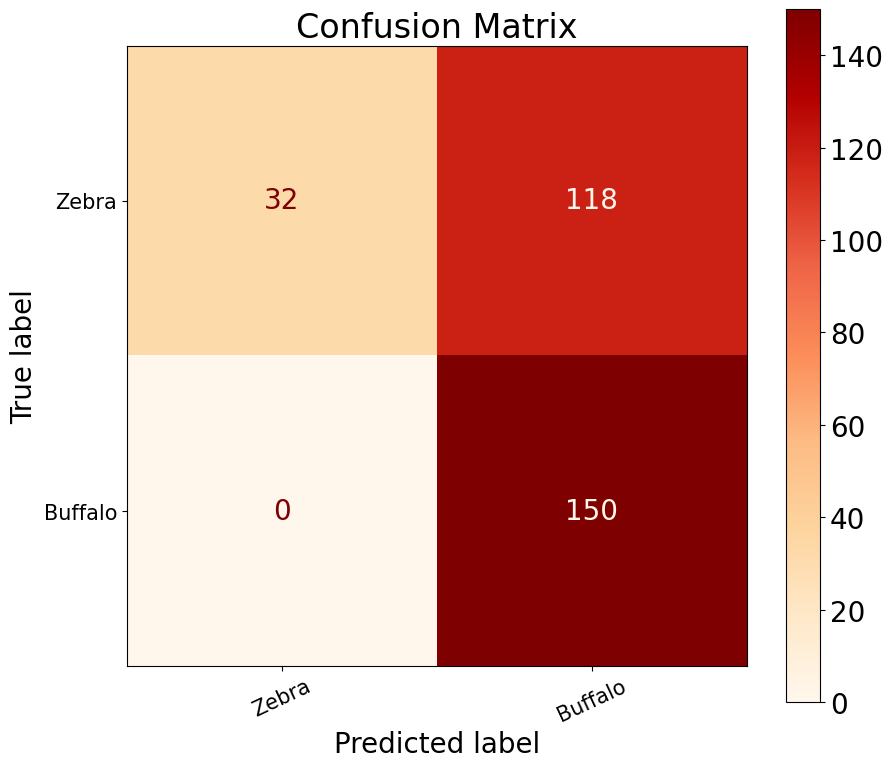

In [44]:
# Magic function that renders the figure in a jupyter notebook
# instead of displaying a figure object
%matplotlib inline


# Setting default size of the plot
# Setting default fontsize used in the plot
plt.rcParams['figure.figsize'] = (10.0, 9.0)
plt.rcParams['font.size'] = 20


# Implementing visualization of Confusion Matrix
display_c_m = ConfusionMatrixDisplay(c_m, display_labels=labels)


# Plotting Confusion Matrix
# Setting colour map to be used
display_c_m.plot(cmap='OrRd', xticks_rotation=25)
# Other possible options for colour map are:
# 'autumn_r', 'Blues', 'cool', 'Greens', 'Greys', 'PuRd', 'copper_r'


# Setting fontsize for xticks and yticks
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


# Giving name to the plot
plt.title('Confusion Matrix', fontsize=24)


# Saving plot
plt.savefig('confusion_matrix.png', transparent=True, dpi=500)


# Showing the plot
plt.show()